In [64]:
# Import the libraries we will use:

import imageio
import numpy as np
import pandas as pd
from PIL import Image
from skimage import data, io
import os

## Step 1
In this step we will convert all coloured monkey photos into black & white ones of a fixed size.
This step can be omitted if the photos are already there.

In [69]:
# Create the Black-White monkey photos from the coloured ones and standardize on shape.

def black_white_photos_missing(directory):
    """
    We simply see if files exist in the "output" directory as proof
    that this step has already been run.
    """
    file_list = os.listdir(directory)
    return(len(file_list) == 0)

# Directories for datasets:
photo_root = "./monkeys"

source_training_photos = photo_root + "/source_dataset/training"
dest_training_photos = photo_root + "/derived_dataset/training"

source_validation_photos = photo_root + "/source_dataset/validation"
dest_validation_photos = photo_root + "/derived_dataset/validation"

# Restrict our analysis to following monkey categories:
monkey_groups = ["n0", "n1", "n2"]

if black_white_photos_missing(dest_training_photos):
    # Process "training" dataset:
    #for group in monkey_groups:
    print("Missing")   


Missing


In [65]:
img = Image.open(source_training_photos + "/n0/n0018.jpg")
img.show()

xx = img.convert("L").resize((350,350))

xx.show()

In [61]:
xx.size

(350, 350)

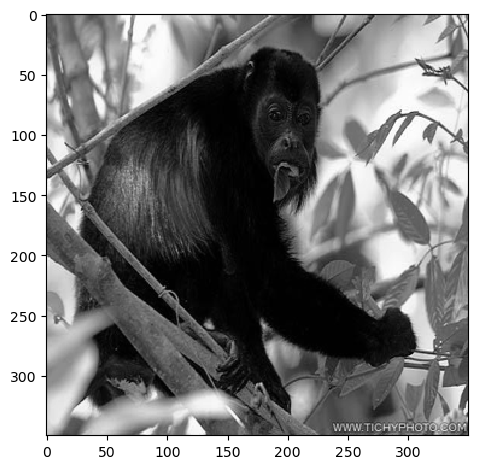

In [62]:
data = np.array(xx.getdata(), dtype = np.uint8).reshape(350,350)
io.imshow(data)